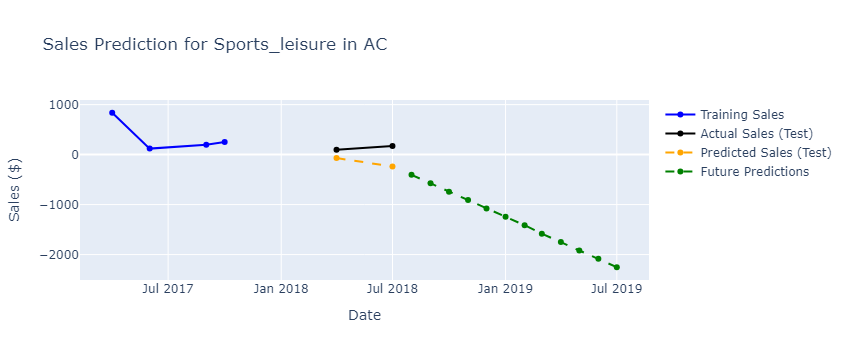

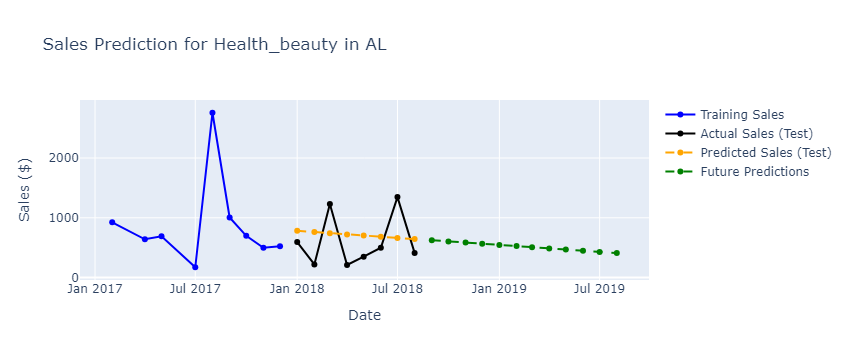

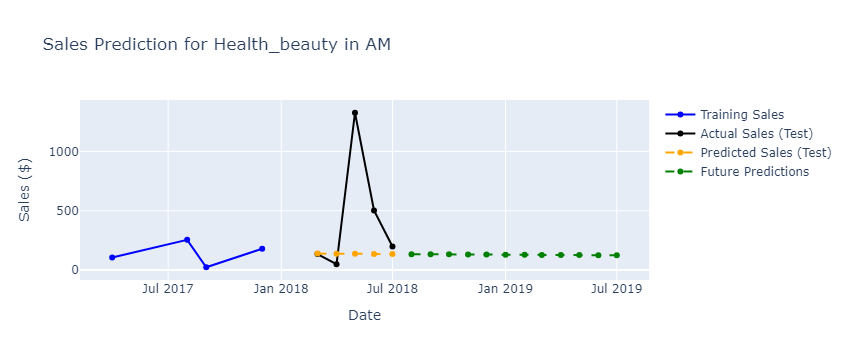

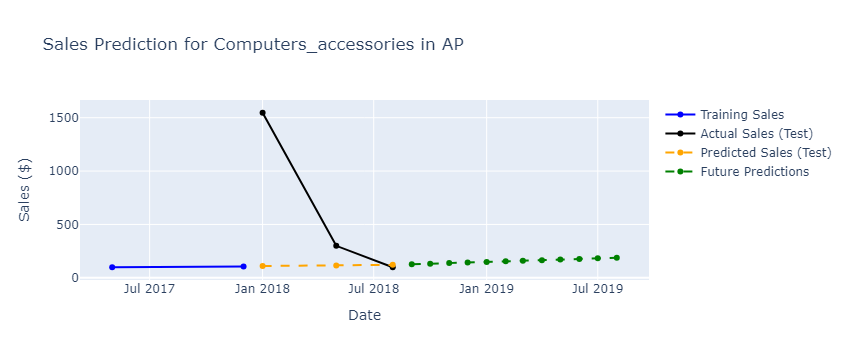

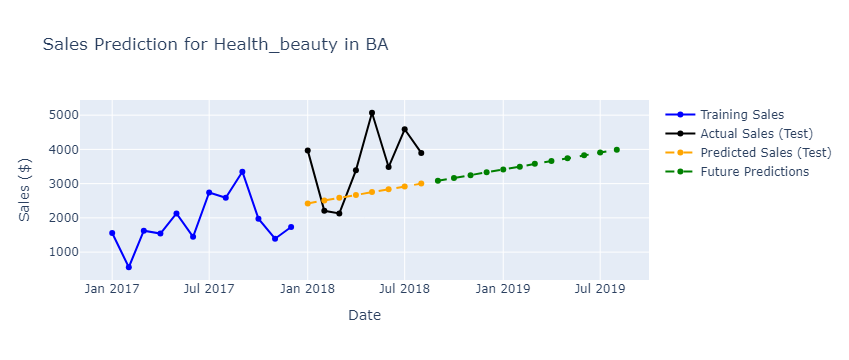

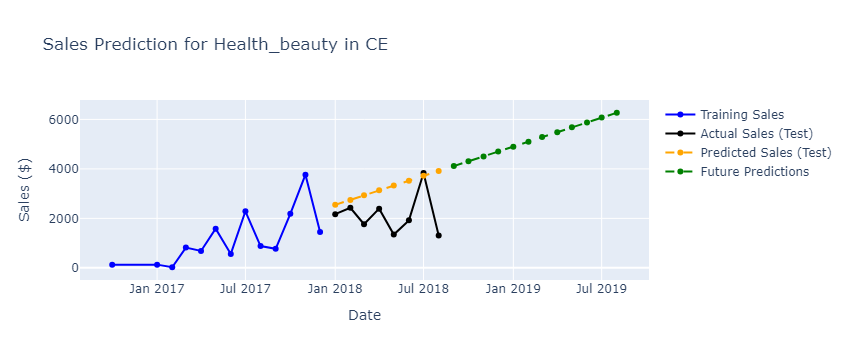

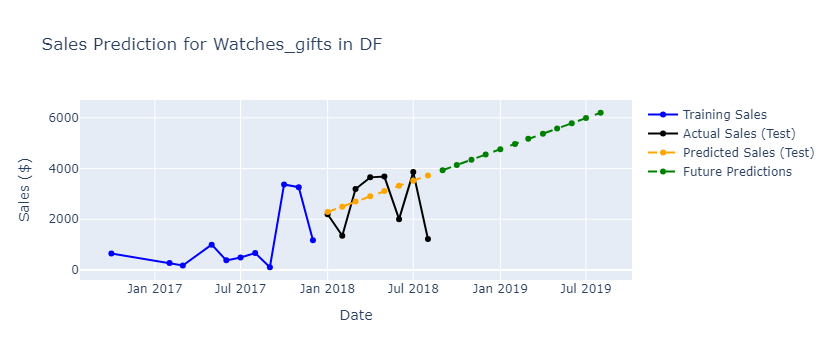

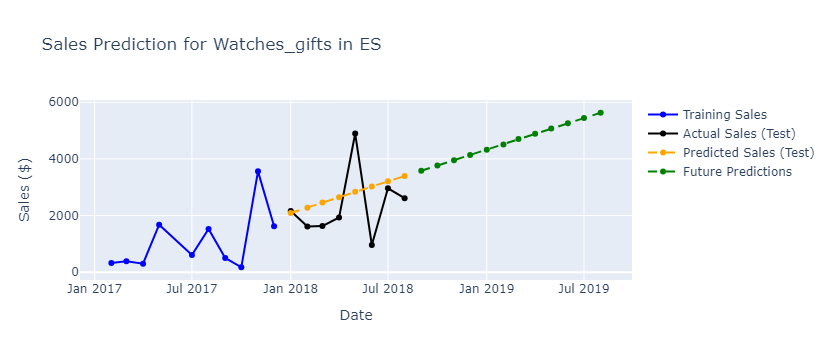

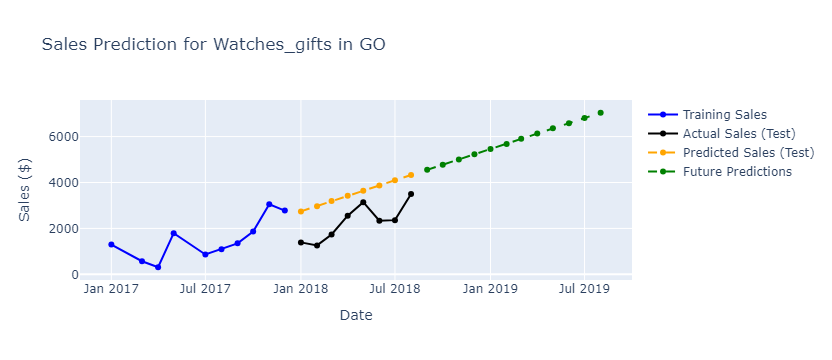

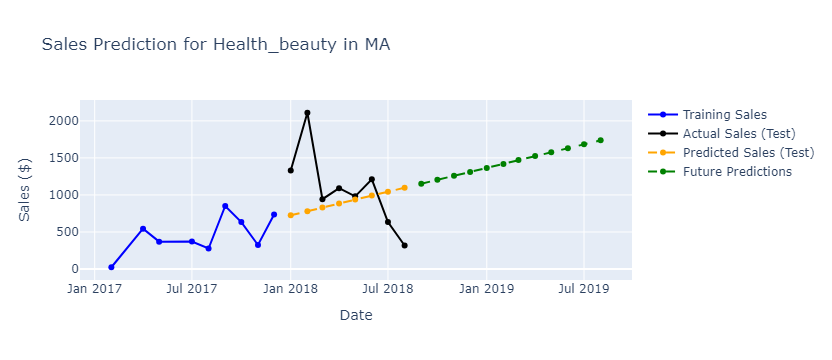

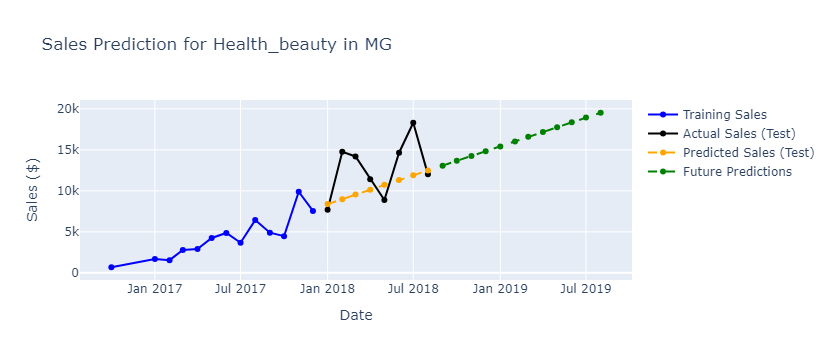

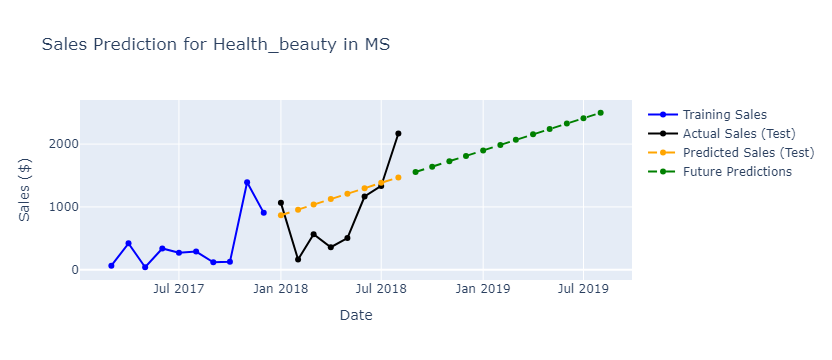

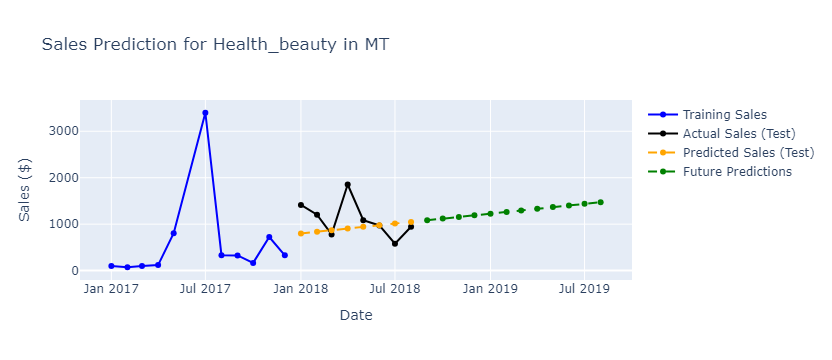

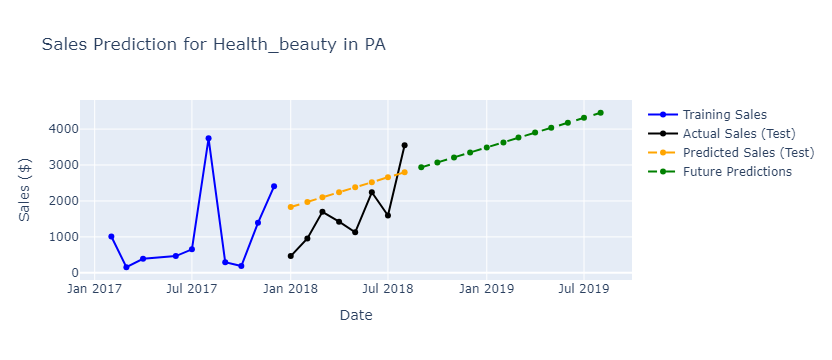

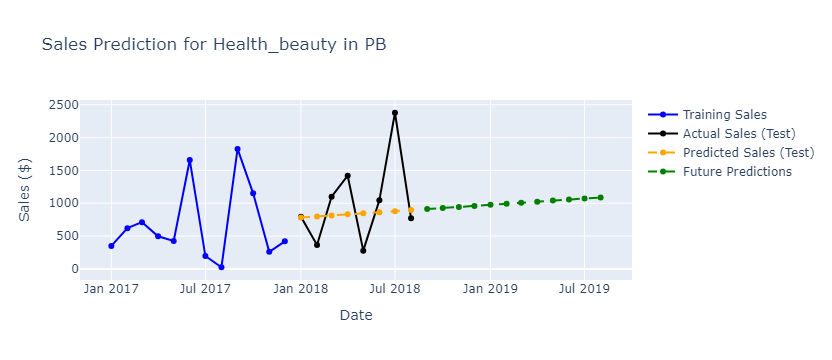

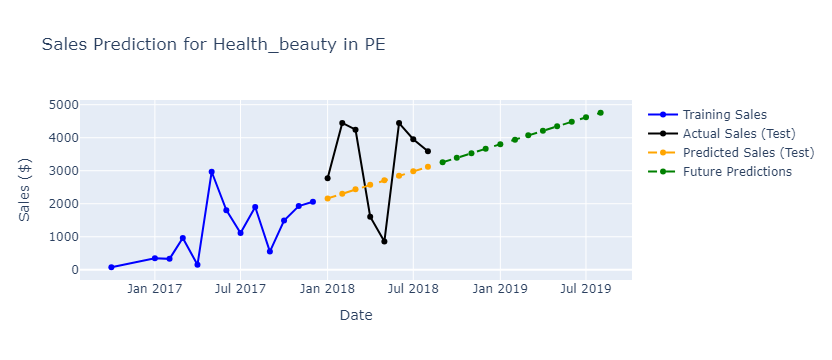

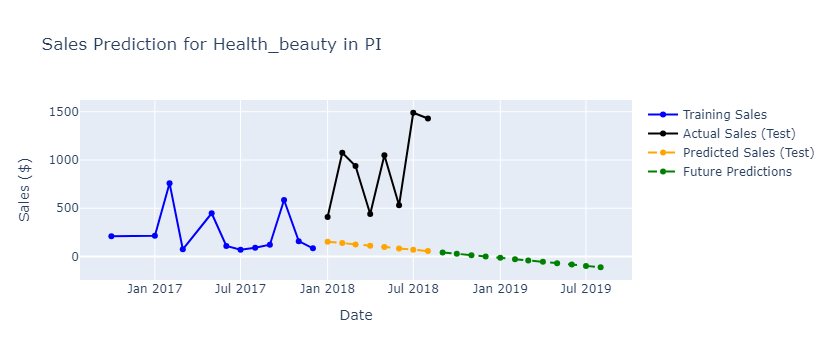

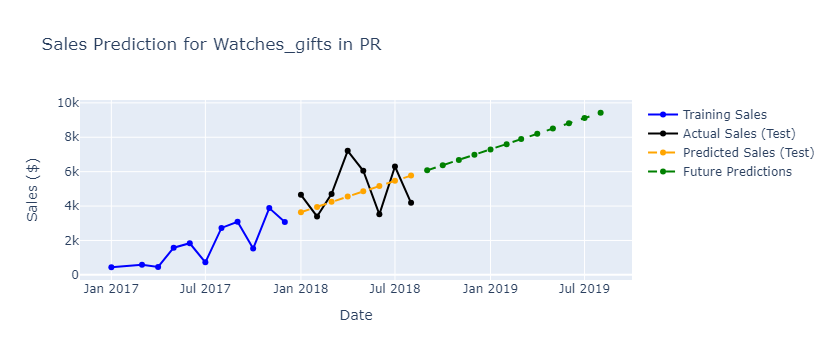

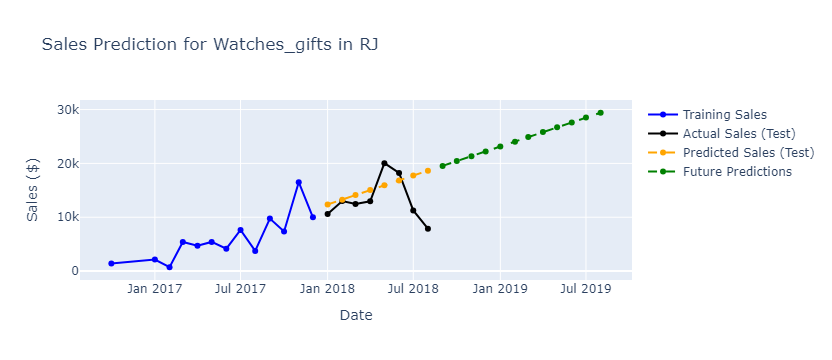

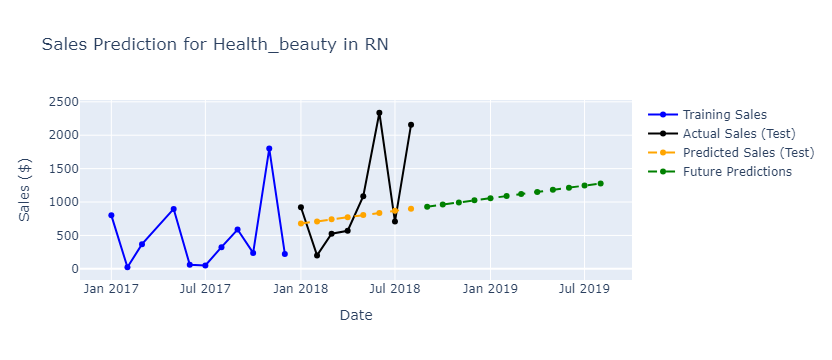

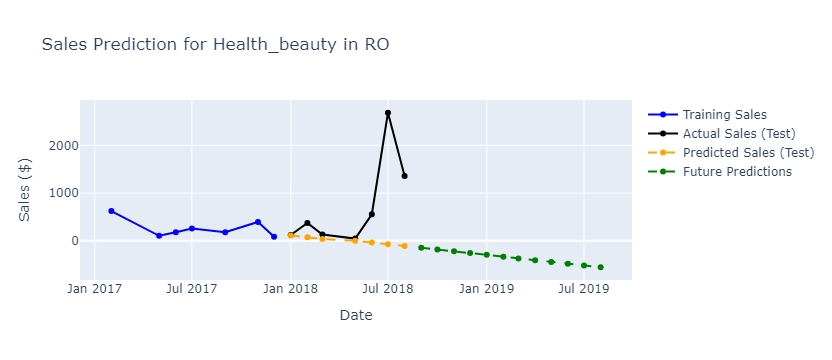

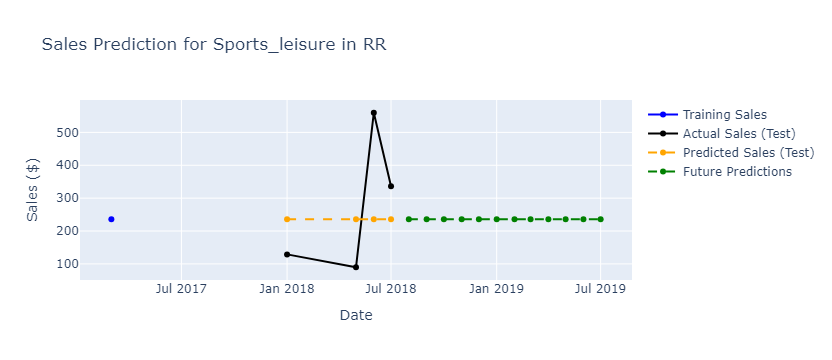

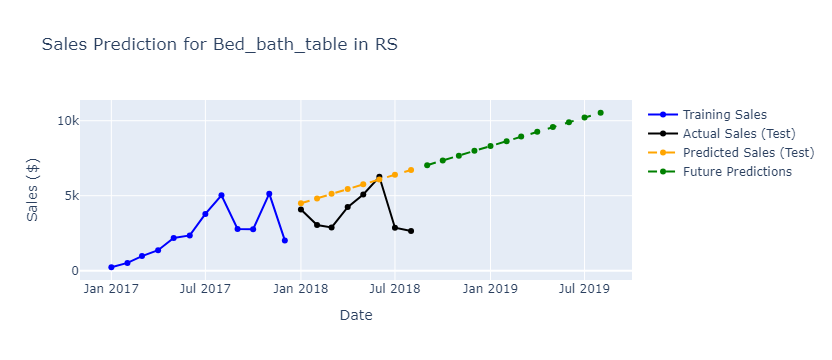

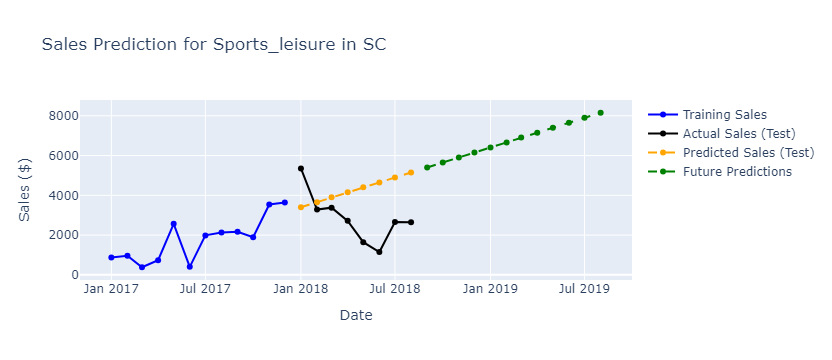

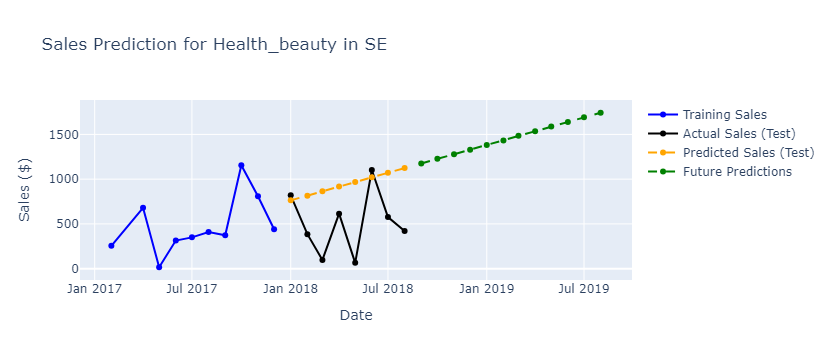

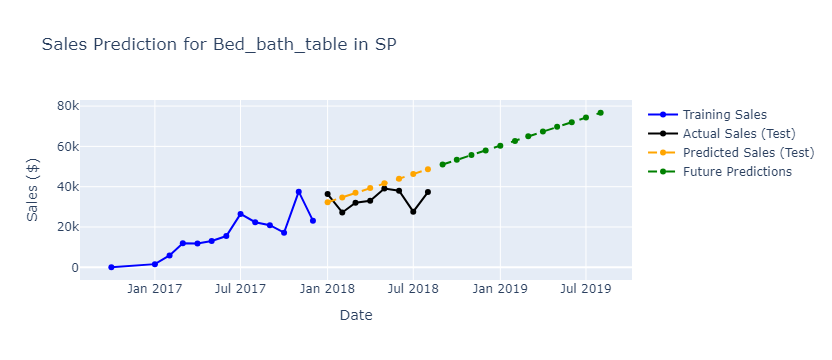

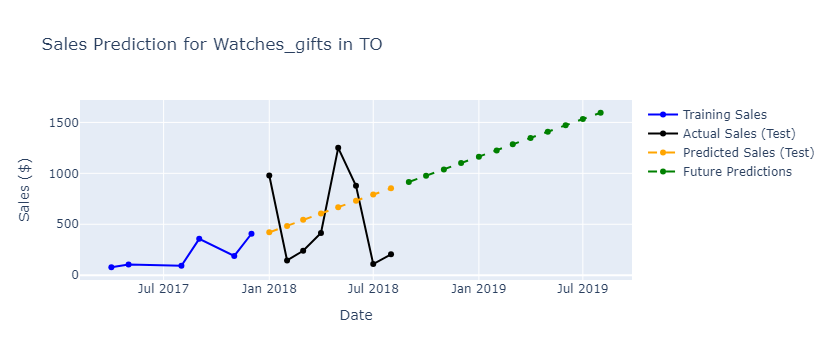

                                    MAE           MSE         RMSE   R² Score
AC - sports_leisure          289.274000  9.840867e+04   313.701558 -69.580499
AL - health_beauty           397.648056  1.883736e+05   434.020297  -0.110221
AM - health_beauty           342.039000  3.115580e+05   558.173825  -0.427274
AP - computers_accessories   547.343333  6.985249e+05   835.778002  -0.704466
BA - health_beauty          1070.169834  1.575336e+06  1255.123864  -0.673238
CE - health_beauty          1115.598365  1.940777e+06  1393.117888  -2.415051
DF - watches_gifts           900.352705  1.320622e+06  1149.183346  -0.291198
ES - watches_gifts           928.175205  1.350482e+06  1162.102490  -0.068322
GO - watches_gifts          1246.681932  1.738018e+06  1318.339003  -2.125365
MA - health_beauty           463.424125  3.777224e+05   614.591219  -0.549848
MG - health_beauty          3056.732102  1.409802e+07  3754.732655  -0.350616
MS - health_beauty           476.829455  3.105411e+05   557.2621

In [11]:
import pandas as pd
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the cleaned dataset
full_data = pd.read_csv('cleaned_full_data.csv')

# Step 1: Group by state and product category, summing the sales
state_category_sales = (
    full_data.groupby(['customer_state', 'product_category_name_english'])['price']
    .sum()
    .reset_index()
)

# Find the most popular category in each state
most_popular_categories = state_category_sales.loc[
    state_category_sales.groupby('customer_state')['price'].idxmax()
]

# Prepare a summary dictionary for the results
results_summary = {}

# Step 2: Time Series Analysis for Each Most Popular Category by State
for _, row in most_popular_categories.iterrows():
    state = row['customer_state']
    category_name = row['product_category_name_english']
    
    # Filter data for the specific state and category
    category_data = full_data[(full_data['customer_state'] == state) & 
                              (full_data['product_category_name_english'] == category_name)]

    # Group by year and month, summing up the sales
    category_monthly_sales = category_data.groupby(['order_year', 'order_month'])['price'].sum().reset_index()

    # Create a new Date column for easy time-based indexing
    category_monthly_sales['date'] = pd.to_datetime(
        category_monthly_sales['order_year'].astype(str) + '-' + 
        category_monthly_sales['order_month'].astype(str).str.zfill(2) + '-01'
    )

    # Sort values by date
    category_monthly_sales = category_monthly_sales.sort_values(by='date').reset_index(drop=True)

    # Split data: 2016-2017 for training, 2018 for testing
    train_data = category_monthly_sales[category_monthly_sales['date'] < '2018-01-01'].copy()
    test_data = category_monthly_sales[category_monthly_sales['date'] >= '2018-01-01'].copy()

    # Set up features and target variable
    train_data.loc[:, 'time_index'] = range(len(train_data))
    test_data.loc[:, 'time_index'] = range(len(train_data), len(train_data) + len(test_data))
    X_train = train_data[['time_index']]
    y_train = train_data['price']
    X_test = test_data[['time_index']]
    y_test = test_data['price']

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions for the testing set
    y_pred_test = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    # Store the results in the summary dictionary
    results_summary[f'{state} - {category_name}'] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2
    }

    # Future Predictions
    future_steps = 12  # Number of future months to predict
    last_date = category_monthly_sales['date'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')
    
    # Prepare future input for the model
    future_time_index = range(len(train_data) + len(test_data), len(train_data) + len(test_data) + future_steps)
    X_future = pd.DataFrame({'time_index': future_time_index})

    # Make future predictions
    future_pred = model.predict(X_future)

    # Combine actual and predicted values for plotting
    all_dates = pd.concat([category_monthly_sales['date'], pd.Series(future_dates)])
    all_sales = pd.concat([category_monthly_sales['price'], pd.Series(future_pred, index=future_dates)])
    
    # Plotting with Plotly (optional)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=category_monthly_sales['date'], y=y_train, mode='lines+markers', name='Training Sales', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=test_data['date'], y=y_test, mode='lines+markers', name='Actual Sales (Test)', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=test_data['date'], y=y_pred_test, mode='lines+markers', name='Predicted Sales (Test)', line=dict(dash='dash', color='orange')))
    fig.add_trace(go.Scatter(x=future_dates, y=future_pred, mode='lines+markers', name='Future Predictions', line=dict(dash='dash', color='green')))
    fig.update_layout(title=f'Sales Prediction for {category_name.capitalize()} in {state}', xaxis_title='Date', yaxis_title='Sales ($)', hovermode="x unified")
    fig.show()

# Convert results summary to DataFrame for better visualization
results_df = pd.DataFrame(results_summary).T

# Display the results summary
print(results_df)
